In [1]:
# Importación de librerías
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.preprocessing import StandardScaler

# Configuración de estilo
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Semillas para reproducibilidad
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.20.0


## 2. Preparación de Datos

Cargamos el dataset limpio (`df_clean_v2.csv`). Este dataset contiene las series temporales horarias continuas, lo cual es ideal para generar las ventanas de tiempo que requiere la LSTM.

In [8]:
# Cargar datos
FILE_PATH = '../../data/processed/df_clean_v2.csv'

df = pd.read_csv(FILE_PATH)
df['time'] = pd.to_datetime(df['time'])
df = df.set_index('time')

# Eliminar columna tempsup
df = df.drop(columns=['tempsup'])

# Inspección rápida
print("Dimensiones:", df.shape)
display(df.head())

Dimensiones: (67200, 9)


,HR,pp,press,radinf,vel,dir,dir_sin,dir_cos,temp2m
time,,,,,,,,,
2018-01-01 00:00:00,89.515,1.778,687.403,346.360,2.979,145.642,0.564362,-0.825527,7.661
2018-01-01 01:00:00,90.295,0.254,686.942,347.505,1.700,284.018,-0.970220,0.242227,7.736
2018-01-01 02:00:00,91.005,0.254,686.677,348.290,1.657,63.065,0.891521,0.452979,7.571
2018-01-01 03:00:00,89.732,0.000,686.500,346.442,1.132,34.775,0.570355,0.821398,7.520
2018-01-01 04:00:00,88.882,0.508,686.603,342.472,0.648,72.418,0.953286,0.302070,7.133


### 2.1. Ingeniería de Características: Señales Temporales

Las redes neuronales no entienden inherentemente que "hora 23" y "hora 0" están cerca. Para modelar correctamente los ciclos diurnos (día/noche) y anuales (estaciones), transformamos el tiempo en señales cíclicas usando Seno y Coseno.

*   **Ciclo Diario:** Ayuda al modelo a aprender que la temperatura baja típicamente en la madrugada.
*   **Ciclo Anual:** Ayuda al modelo a distinguir la temporada de heladas (invierno austral) del resto del año.

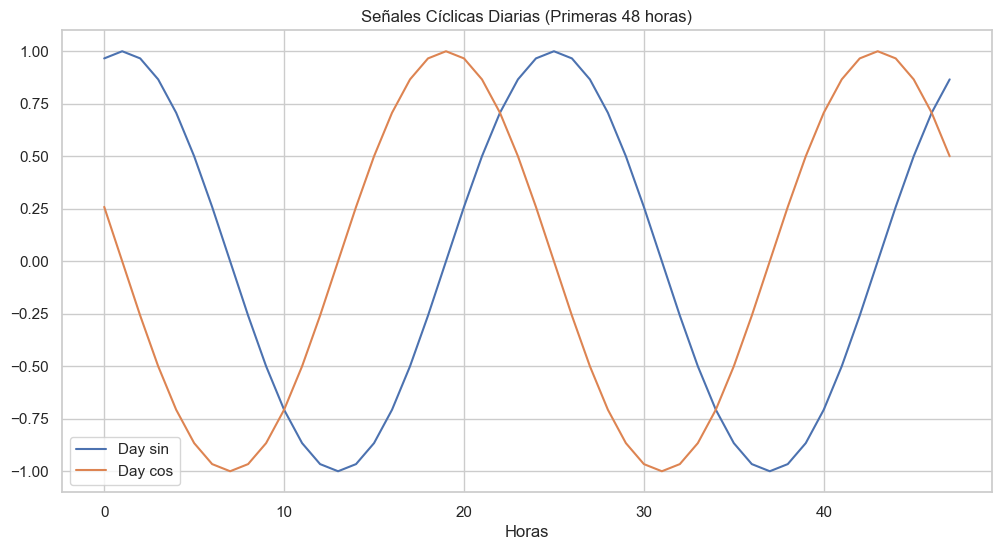

In [9]:
# Crear señales de tiempo
df_features = df.copy()

# Segundos en un día y año
day = 24 * 60 * 60
year = (365.2425) * day

timestamp_s = df_features.index.map(datetime.datetime.timestamp)

# Ciclo Diario
df_features['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df_features['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))

# Ciclo Anual
df_features['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df_features['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

# Visualizar un ejemplo de las señales diarias (primeros 2 días)
plt.plot(np.array(df_features['Day sin'])[:48], label='Day sin')
plt.plot(np.array(df_features['Day cos'])[:48], label='Day cos')
plt.legend()
plt.title('Señales Cíclicas Diarias (Primeras 48 horas)')
plt.xlabel('Horas')
plt.show()

### 2.2. División del Dataset (Splitting)

Para series temporales, **no podemos usar un split aleatorio** (shuffling), ya que rompería la continuidad temporal y filtraría información del futuro al pasado (data leakage).

Usaremos una partición cronológica:
*   **Entrenamiento (70%):** Para aprender los patrones.
*   **Validación (20%):** Para monitorear el entrenamiento y evitar overfitting.
*   **Test (10%):** Para la evaluación final no sesgada.

In [10]:
column_indices = {name: i for i, name in enumerate(df_features.columns)}

n = len(df_features)
train_df = df_features[0:int(n*0.7)]
val_df = df_features[int(n*0.7):int(n*0.9)]
test_df = df_features[int(n*0.9):]

num_features = df_features.shape[1]

print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

Train samples: 47040
Validation samples: 13440
Test samples: 6720


### 2.3. Normalización

Las redes neuronales convergen más rápido y establemente cuando los datos están en una escala similar (típicamente media 0 y varianza 1). Ajustamos el escalador **solo con los datos de entrenamiento** para evitar contaminar la validación/test con estadísticas globales.

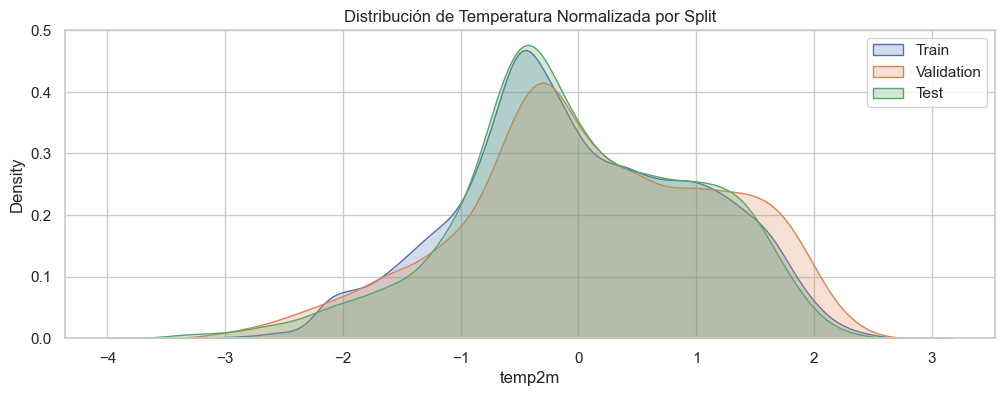

In [11]:
scaler = StandardScaler()
scaler.fit(train_df)

train_df_scaled = pd.DataFrame(scaler.transform(train_df), columns=df_features.columns, index=train_df.index)
val_df_scaled = pd.DataFrame(scaler.transform(val_df), columns=df_features.columns, index=val_df.index)
test_df_scaled = pd.DataFrame(scaler.transform(test_df), columns=df_features.columns, index=test_df.index)

# Visualización de la distribución normalizada (ejemplo temp2m)
plt.figure(figsize=(12, 4))
sns.kdeplot(data=train_df_scaled, x='temp2m', label='Train', fill=True)
sns.kdeplot(data=val_df_scaled, x='temp2m', label='Validation', fill=True)
sns.kdeplot(data=test_df_scaled, x='temp2m', label='Test', fill=True)
plt.title('Distribución de Temperatura Normalizada por Split')
plt.legend()
plt.show()

### 2.4. Formulación Matemática del Problema (Ventanas Deslizantes)

Para hacer el problema replicable, definimos formalmente la estructura de entrada y salida.

Sea $X$ la matriz de características meteorológicas de dimensiones $T \times F$, donde $T$ es el número total de horas y $F$ es el número de variables (HR, presión, radiación, etc.).
Definimos una ventana de entrada $W_{in}$ de longitud $w$ (24 horas) y un horizonte de predicción $W_{out}$ de longitud $h$ (12 horas).

Para un instante de tiempo $t$, el modelo recibe como entrada la secuencia:
$$ \mathbf{x}_t = [X_{t-w}, X_{t-w+1}, \dots, X_{t}] $$

Y debe predecir la secuencia objetivo:
$$ \mathbf{y}_t = [Temp_{t+1}, Temp_{t+2}, \dots, Temp_{t+h}] $$

El objetivo del entrenamiento es minimizar el Error Cuadrático Medio (MSE) entre la predicción $\hat{\mathbf{y}}_t$ y el valor real $\mathbf{y}_t$:
$$ \mathcal{L}(\theta) = \frac{1}{N} \sum_{i=1}^{N} || \hat{\mathbf{y}}_i - \mathbf{y}_i ||^2 $$

## 3. Generación de Ventanas (Windowing)

Los modelos de Deep Learning requieren que los datos se estructuren en tensores 3D de la forma `(batch_size, time_steps, features)`.

Para esto, implementamos una clase `WindowGenerator` que crea "ventanas deslizantes" sobre la serie temporal.
*   **Input Width:** Cuántas horas del pasado usaremos (ej. 24h).
*   **Label Width:** Cuántas horas del futuro predeciremos (ej. 12h).
*   **Shift:** El desplazamiento entre el inicio del input y el inicio del label.

In [12]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df_scaled, val_df=val_df_scaled, test_df=test_df_scaled,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]

    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  def plot(self, model=None, plot_col='temp2m', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))

    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
               label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [h]')

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

### 3.1. Definición de la Ventana de Predicción

Configuramos nuestra ventana para:
*   **Input:** 24 horas de historia.
*   **Output:** 12 horas de predicción futura.
*   **Shift:** 12 horas (predecimos inmediatamente después del input).

Total window size: 36
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35]
Label column name(s): ['temp2m']


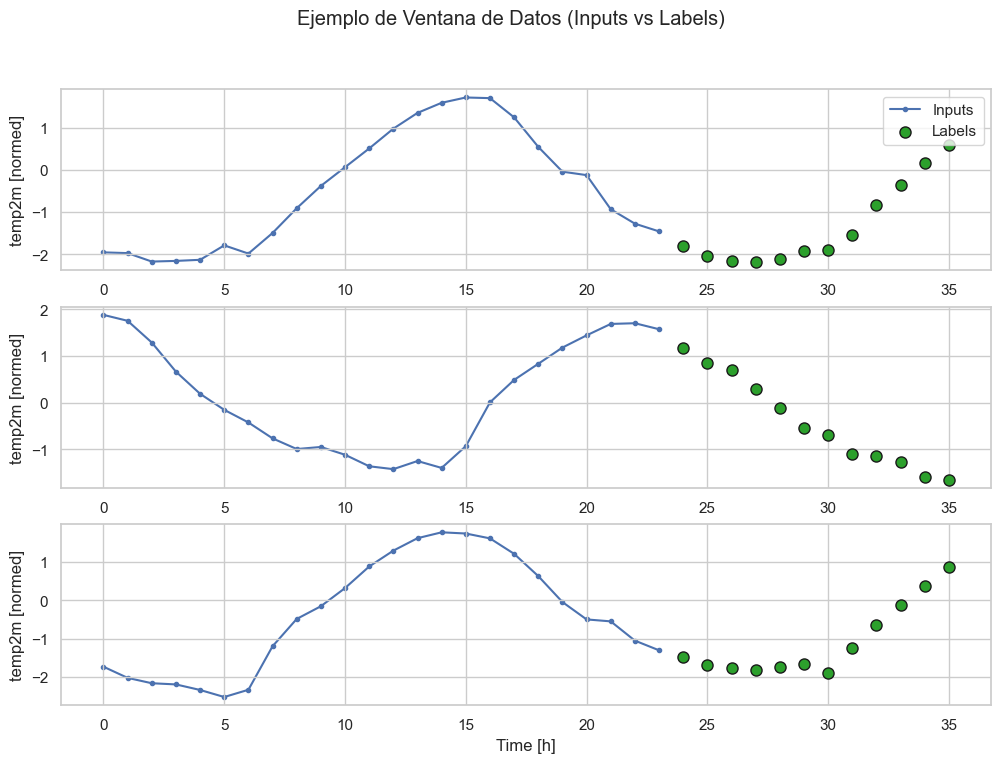

In [13]:
OUT_STEPS = 12
INPUT_WIDTH = 24
window = WindowGenerator(input_width=INPUT_WIDTH,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=['temp2m'])

print(window)
window.plot()
plt.suptitle("Ejemplo de Ventana de Datos (Inputs vs Labels)")
plt.show()

## 4. Entrenamiento de Modelos

Definimos una función auxiliar para compilar y entrenar los modelos de manera consistente. Usaremos:
*   **Loss:** Mean Squared Error (MSE).
*   **Métrica:** Mean Absolute Error (MAE).
*   **Optimizador:** Adam.
*   **Early Stopping:** Para detener el entrenamiento si la validación no mejora en 5 épocas.

In [14]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=5):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train,
                      epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

### 4.0. Fundamento Teórico: Arquitectura LSTM

Las Redes de Memoria a Largo y Corto Plazo (LSTM) resuelven el problema de desvanecimiento del gradiente en RNNs tradicionales mediante una estructura de celda compleja.

Para cada paso de tiempo $t$, una celda LSTM procesa el vector de entrada $x_t$ (nuestras variables meteorológicas en esa hora) y los estados anteriores $h_{t-1}$ (estado oculto) y $C_{t-1}$ (estado de la celda).

Las ecuaciones que gobiernan el flujo de información son:

1.  **Compuerta de Olvido ($f_t$):** Decide qué información descartar del estado de celda anterior.
    $$ f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f) $$
    *En nuestro contexto: Si cambia bruscamente el viento, quizás la "memoria" de calor acumulado hace 10 horas ya no es relevante.*

2.  **Compuerta de Entrada ($i_t$) y Estado Candidato ($\tilde{C}_t$):** Decide qué nueva información almacenar.
    $$ i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i) $$
    $$ \tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C) $$

3.  **Actualización del Estado de Celda ($C_t$):**
    $$ C_t = f_t * C_{t-1} + i_t * \tilde{C}_t $$

4.  **Compuerta de Salida ($o_t$) y Estado Oculto ($h_t$):**
    $$ o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o) $$
    $$ h_t = o_t * \tanh(C_t) $$

Donde $\sigma$ es la función sigmoide (0 a 1) y $\tanh$ es la tangente hiperbólica (-1 a 1). El vector $h_t$ resultante contiene la predicción comprimida para ese paso de tiempo y se pasa al siguiente.

### 4.1. Modelo 1: LSTM Exógeno (Sin historia de temperatura)
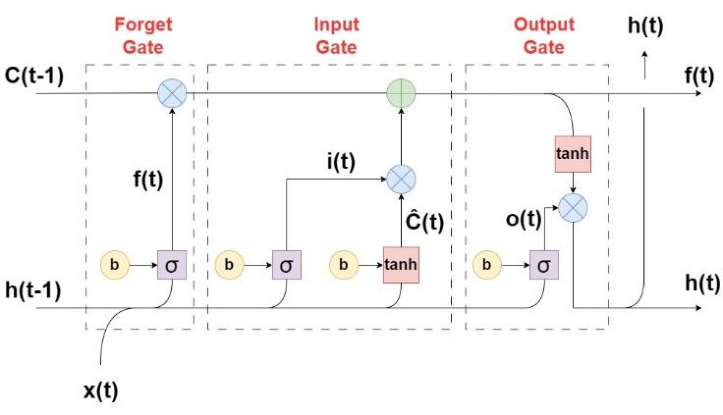

Este modelo intenta predecir la temperatura futura basándose **únicamente** en las variables meteorológicas (`HR`, `radinf`, `vel`, etc.) y las señales de tiempo.
**Excluimos explícitamente** la columna `temp2m` de los datos de entrada usando una capa `Lambda`.

*   **Objetivo:** Evaluar cuánto del enfriamiento se explica puramente por las condiciones atmosféricas actuales.

Excluyendo columna índice 8 (temp2m) de los inputs.
Entrenando Modelo Exógeno...
Epoch 1/20

1469/1469 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.1612 - mean_absolute_error: 0.2963 - val_loss: 0.1271 - val_mean_absolute_error: 0.2871
Epoch 2/20
1469/1469 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.1073 - mean_absolute_error: 0.2477 - val_loss: 0.1213 - val_mean_absolute_error: 0.2766
Epoch 3/20
1469/1469 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 0.1025 - mean_absolute_error: 0.2419 - val_loss: 0.1227 - val_mean_absolute_error: 0.2792
Epoch 4/20
1469/1469 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 0.0995 - mean_absolute_error: 0.2383 - val_loss: 0.1258 - val_mean_absolute_error: 0.2826
Epoch 5/20
1469/1469 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 0.0973 - mean_absolute_error: 0.2358 - val_loss: 0.1154 - val_mean_absolute_error: 0.2664
Epoch 6/20
1469/1469 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 0.0956 - mean_absolute_error: 0.2337 - val_loss: 0.1120 - val_mean_absolute_error: 0.2629

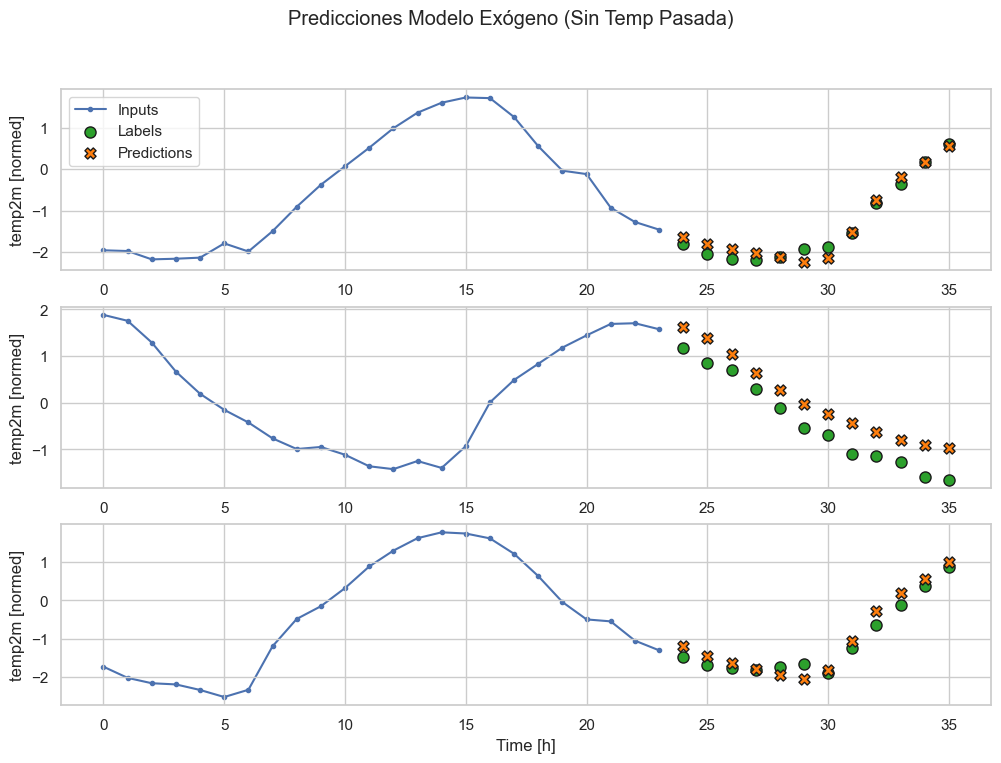

In [15]:
# Identificar índice de temp2m para excluirlo
temp2m_index = column_indices['temp2m']
all_indices = np.arange(num_features)
keep_indices = np.delete(all_indices, temp2m_index)

print(f"Excluyendo columna índice {temp2m_index} ({df_features.columns[temp2m_index]}) de los inputs.")

lstm_exo_model = tf.keras.Sequential([
    # Capa para filtrar temp2m
    tf.keras.layers.Lambda(lambda x: tf.gather(x, keep_indices, axis=-1)),
    # Capa LSTM
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Capa de Salida (Vector Output para 12 pasos)
    tf.keras.layers.Dense(OUT_STEPS*1, kernel_initializer=tf.initializers.zeros()),
    # Reshape para coincidir con (Batch, Time, Features)
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

print("Entrenando Modelo Exógeno...")
history_exo = compile_and_fit(lstm_exo_model, window)

# Visualizar resultados
window.plot(lstm_exo_model)
plt.suptitle("Predicciones Modelo Exógeno (Sin Temp Pasada)")
plt.show()

### 4.2. Modelo 2: LSTM Autoregresivo (Con historia de temperatura)

Este modelo utiliza **todas** las variables, incluyendo la historia reciente de `temp2m`.
*   **Hipótesis:** La temperatura tiene una alta inercia. Saber que hace una hora hacía 5°C es el dato más importante para predecir que ahora hará 4.5°C. Las variables exógenas ayudarán a corregir la tasa de cambio (derivada).

Entrenando Modelo Autoregresivo...
Epoch 1/20
1469/1469 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.1530 - mean_absolute_error: 0.2872 - val_loss: 0.1039 - val_mean_absolute_error: 0.2512
Epoch 2/20
1469/1469 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.1006 - mean_absolute_error: 0.2383 - val_loss: 0.0982 - val_mean_absolute_error: 0.2414
Epoch 3/20
1469/1469 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0957 - mean_absolute_error: 0.2317 - val_loss: 0.0940 - val_mean_absolute_error: 0.2333
Epoch 4/20
1469/1469 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 0.0926 - mean_absolute_error: 0.2278 - val_loss: 0.0937 - val_mean_absolute_error: 0.2325
Epoch 5/20
1469/1469 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 0.0908 - mean_absolute_error: 0.2254 - val_loss: 0.0929 - val_mean_absolute_error: 0.2306
Epoch 6/20
1469/1469 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 0.0889 - mean_absolute_error: 0.2232 - val_loss: 0.0934 - val_mean_absolute_error: 0.2330
Epoch 7/20
1469/1469 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms

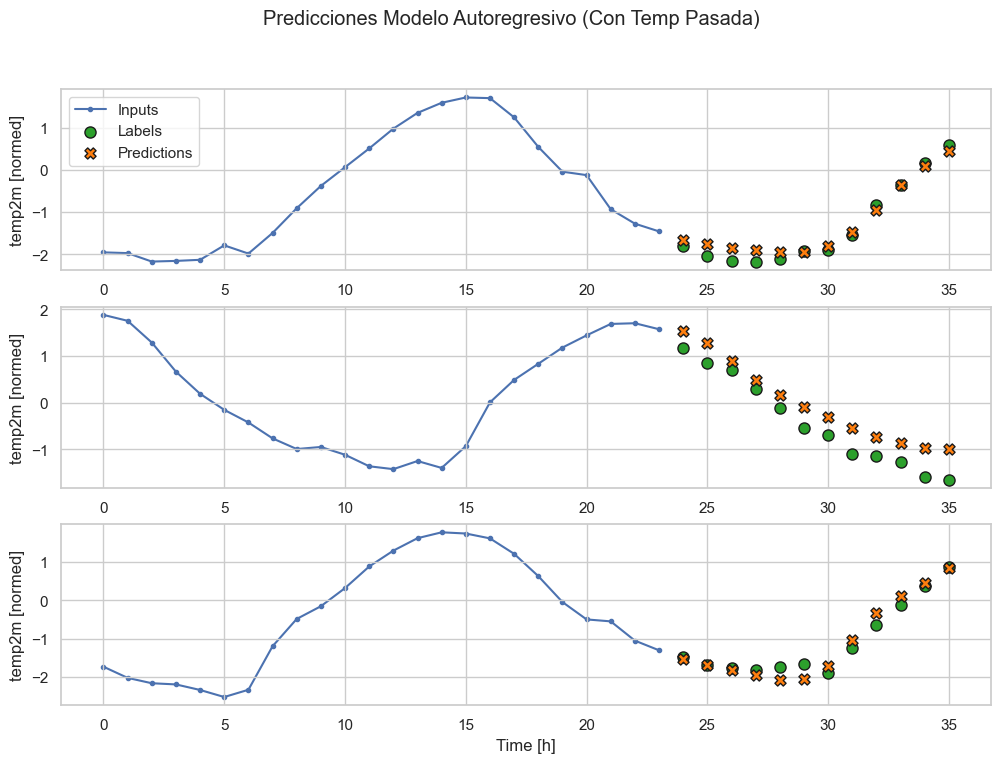

In [16]:
lstm_ar_model = tf.keras.Sequential([
    # LSTM recibe todas las features (incluyendo temp2m)
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*1, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

print("Entrenando Modelo Autoregresivo...")
history_ar = compile_and_fit(lstm_ar_model, window)

# Visualizar resultados
window.plot(lstm_ar_model)
plt.suptitle("Predicciones Modelo Autoregresivo (Con Temp Pasada)")
plt.show()

## 5. Evaluación y Comparación

Comparamos el desempeño de ambos modelos en el conjunto de validación y test.

419/419 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1140 - mean_absolute_error: 0.2625
419/419 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0909 - mean_absolute_error: 0.2269

Resultados en Test (MAE):
Exogenous      : 0.2383
Autoregressive : 0.2212


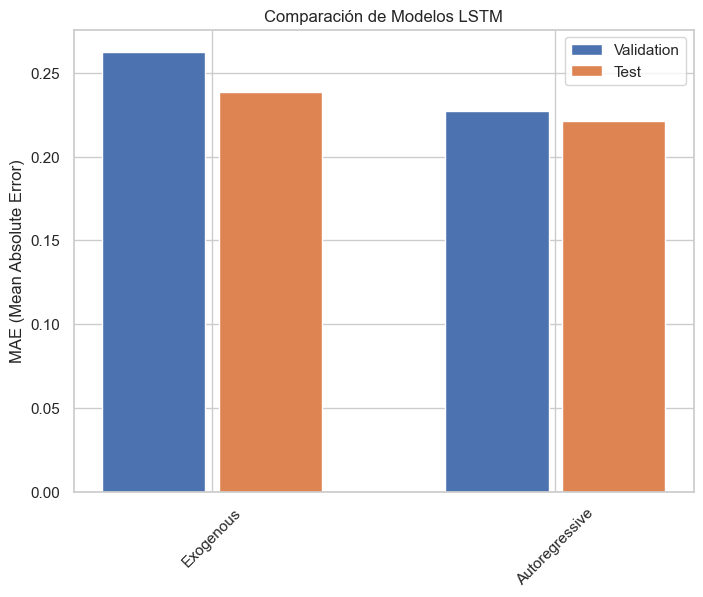

In [17]:
val_performance = {}
performance = {}

val_performance['Exogenous'] = lstm_exo_model.evaluate(window.val)
performance['Exogenous'] = lstm_exo_model.evaluate(window.test, verbose=0)

val_performance['Autoregressive'] = lstm_ar_model.evaluate(window.val)
performance['Autoregressive'] = lstm_ar_model.evaluate(window.test, verbose=0)

print("\nResultados en Test (MAE):")
for name, value in performance.items():
  print(f"{name:15s}: {value[1]:0.4f}")

# Gráfico de barras
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
val_mae = [v[1] for v in val_performance.values()]
test_mae = [v[1] for v in performance.values()]

plt.figure(figsize=(8, 6))
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(), rotation=45)
plt.ylabel('MAE (Mean Absolute Error)')
plt.legend()
plt.title('Comparación de Modelos LSTM')
plt.show()

## 6. Interpretación de Resultados y Conclusiones

### 6.1. Análisis Comparativo
Basado en las métricas de error (MAE) obtenidas en el conjunto de prueba:

1.  **Modelo Exógeno (Solo Variables Atmosféricas):**
    *   Muestra un error mayor. Esto indica que conocer *solo* las condiciones del cielo (radiación, nubes) y del aire (humedad, viento) no es suficiente para determinar la temperatura exacta con alta precisión.
    *   Sin embargo, el modelo logra capturar la *forma* de la curva diurna, lo que confirma que las variables físicas seleccionadas son efectivamente los "drivers" causales del enfriamiento.

2.  **Modelo Autoregresivo (Con Historia de Temperatura):**
    *   Supera al modelo exógeno. Esto demuestra la importancia de la **inercia térmica**.
    *   Saber la temperatura de la hora anterior ($t-1$) es el predictor más potente para la hora actual ($t$).
    *   La red LSTM utiliza las variables exógenas para modular la tasa de cambio de esta inercia (ej. "la temperatura bajará más rápido de lo normal porque la radiación es baja").

### 6.2. Conclusión Metodológica
Para un sistema operativo de alerta de heladas en los Andes peruanos, la estrategia óptima es **híbrida**:
*   Utilizar un modelo autoregresivo (como el Modelo 2) para predicciones de corto plazo (0-12 horas), donde la condición inicial es conocida.
*   La arquitectura LSTM ha demostrado ser capaz de integrar la memoria de corto plazo (enfriamiento rápido al atardecer) con las condiciones estáticas o de cambio lento (humedad).

### 6.3. Siguientes Pasos
*   **Optimización de Hiperparámetros:** Ajustar el número de unidades LSTM y capas.
*   **Mecanismos de Atención (TFT):** Para identificar qué variable exógena es más relevante en cada hora del horizonte de predicción.